In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

from model import Model
from MIA import attack

In [2]:
num_classes = 10
treshold = 1

X = np.load(f'data/x.npy')
y = np.load(f'data/y.npy')
model = Model(num_classes=num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.load_weights('models/CIFAR-1.4')

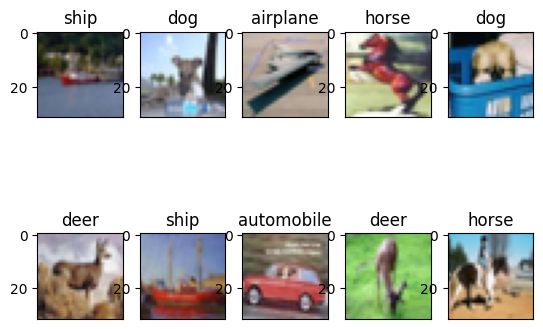

In [3]:
dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat',
        4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship',
        9: 'truck'}
# Visualize the first 10 images
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i])
    plt.title(dict[np.argmax(y[i])])
    plt.xticks([])

In [39]:
"""Note to myself:
    X shape: (50000, 32, 32, 3)
    y shape: (50000, 10)
    Hence 10 classes of images of size 32x32x3

    In X there is a mix of train and test data
    In y their corresponding labels

    Do visualisation of confidence scores to determine which data is train and which is test
    Train data should have high confidence scores
    Test data should have low confidence scores
    """

'Note to myself:\n    X shape: (50000, 32, 32, 3)\n    y shape: (50000, 10)\n    Hence 10 classes of images of size 32x32x3\n\n    In X there is a mix of train and test data\n    In y their corresponding labels\n\n    Do visualisation of confidence scores to determine which data is train and which is test\n    Train data should have high confidence scores\n    Test data should have low confidence scores\n    '

In [4]:
# X : trainning data set
confidence_levels_x = model.predict(X)
confidence_levels_flattened = confidence_levels_x.flatten()

# Index of the highest confidence level
confidence_levels_max_index = np.argmax(confidence_levels_x, axis=1)
# Fill the result 0 matrix with 1 at the index of the highest confidence level
confidence_levels_max = np.zeros_like(confidence_levels_x)
confidence_levels_max[np.arange(len(confidence_levels_x)), confidence_levels_max_index] = 1

# Get the matching indices of the correct predictions
correct_indices = np.where(np.all(confidence_levels_max == y, axis=1))[0]
incorrect_indices = np.setdiff1d(np.arange(len(X)), correct_indices)

157/157 [==============================] - 3s 16ms/step


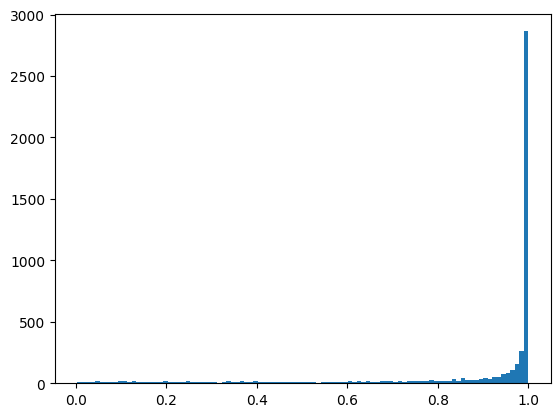

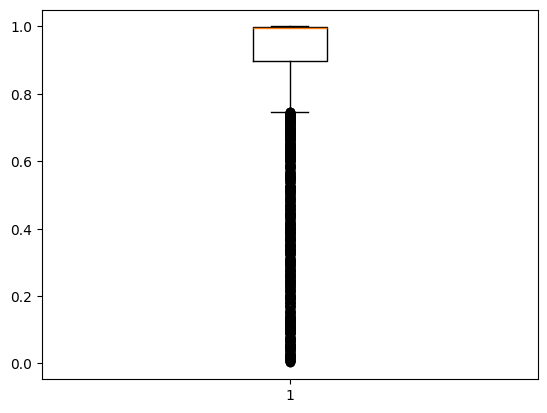

0.9957137
[0 0 1 ... 1 1 0]


In [11]:
lol = np.max(confidence_levels_x, axis=1)
# If the confidence level is above the treshold, it is considered as train data
train_indices = np.where(lol > 0.9579635262489319 )[0]
#test_indices = np.setdiff1d(np.arange(len(X)), train_indices)
# Get the highest confidence level
confidence_levels_max = np.max(confidence_levels_x, axis=1)
# Get the second highest confidence level
confidence_levels_second_max = np.partition(confidence_levels_x, -2, axis=1)[:, -2]
# Get the difference between the highest and second highest confidence level
difference = confidence_levels_max - confidence_levels_second_max
# Plot the difference
plt.hist(difference, bins=100)
plt.show()
# Box plot of the difference
plt.boxplot(difference)
plt.show()
print(np.median(difference))

# Let's say that if the difference is above the median, it is considered as train data
train_indices = np.where(difference > np.median(difference))[0]



# If the prediction is above the treshold, we consider it as a train data
# If the prediction is below the treshold, we consider it as a test data
submission = np.zeros(len(confidence_levels_x), dtype=int)
submission[train_indices] = 1
print(submission)

Number of correct classifications: 4219 - 84.38%
Number of incorrect classifications: 781 - 15.620000000000001%


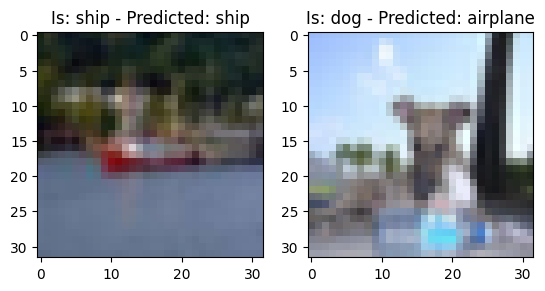

Mean - median confidence level of correct classifications: 0.9579635262489319 - 0.9990679621696472
Mean - median confidence level of incorrect classifications: 0.749079704284668 - 0.7873645424842834


In [60]:
# Interpretation
print(f'Number of correct classifications: {len(correct_indices)} - {len(correct_indices)/len(X)*100}%')
print(f'Number of incorrect classifications: {len(incorrect_indices)} - {len(incorrect_indices)/len(X)*100}%')

# Visualise a correct and incorrect classification
correct = correct_indices[0]
incorrect = incorrect_indices[0]
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X[correct])
plt.title(f'Is: {dict[np.argmax(y[correct])]} - Predicted: {dict[np.argmax(confidence_levels_x[correct])]}')
plt.subplot(1, 2, 2)
plt.imshow(X[incorrect])
plt.title(f'Is: {dict[np.argmax(y[incorrect])]} - Predicted: {dict[np.argmax(confidence_levels_x[incorrect])]}')
plt.show()

"""I am going to infer that the incorrect classifications are the test data 
    and the correct classifications are the train data
    The porportion is 84% train and 16% test, seems reasonable.
    """

# Get the max confidence level of the classificationss
confidence_levels_correct = confidence_levels_x[correct_indices]
confidence_levels_correct_max = np.max(confidence_levels_correct, axis=1)
confidence_levels_incorrect = confidence_levels_x[incorrect_indices]
confidence_levels_incorrect_max = np.max(confidence_levels_incorrect, axis=1)
print(f'Mean - median confidence level of correct classifications: {np.mean(confidence_levels_correct_max)} - {np.median(confidence_levels_correct_max)}')
print(f'Mean - median confidence level of incorrect classifications: {np.mean(confidence_levels_incorrect_max)} - {np.median(confidence_levels_incorrect_max)}')

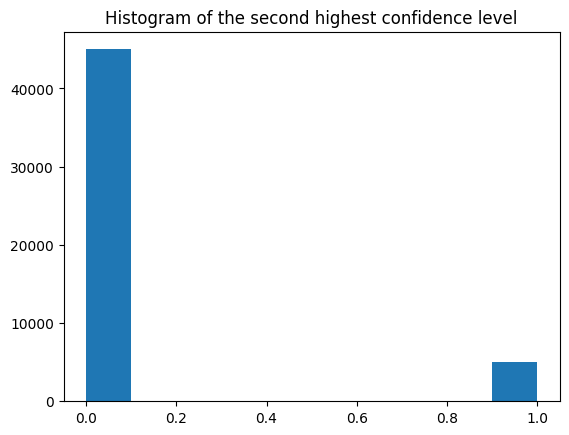

Max values:  [0.8669477  0.52145237 0.99935275 ... 0.99991834 1.         0.8536407 ]
Second max values:  [6.1314691e-02 2.5694650e-01 3.1131657e-04 ... 8.0982107e-05 3.7339101e-10
 5.3220011e-02]
Difference:  [0.805633   0.26450586 0.99904144 ... 0.99983734 1.         0.80042064]


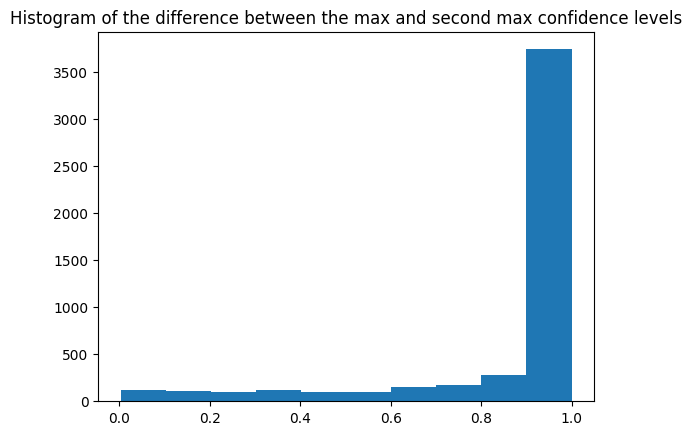

In [6]:
"""
Note: We can notice sometimes there is no clear difference between the max and second max confidence levels
"""
# Get the values of the second highest confidence level
confidence_levels_second = np.zeros_like(confidence_levels_x)
confidence_levels_second[np.arange(len(confidence_levels_x)), np.argpartition(confidence_levels_x, -2, axis=1)[:, -2]] = 1
# Plot an histogram of the second highest confidence level
plt.hist(confidence_levels_second.flatten(), bins=10)
plt.title('Histogram of the second highest confidence level')
plt.show()

# Show the the max and second max confidence levels of each array of confidence_levels_x
# Use np.partition to sort the last two elements in each row
sorted_matrix = np.partition(confidence_levels_x, -2, axis=1)

# The second max and max values are the last two elements in each row
second_max_values = sorted_matrix[:, -2]
max_values = sorted_matrix[:, -1]

print("Max values: ", max_values)
print("Second max values: ", second_max_values)
difference = max_values - second_max_values
print("Difference: ", difference)
# Plot an histogram of the difference between the max and second max confidence levels
plt.hist(difference, bins=10)
plt.title('Histogram of the difference between the max and second max confidence levels')
plt.show()